In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import requests
from PIL import Image
from io import BytesIO
import os

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [43]:
%matplotlib notebook
%matplotlib inline

In [3]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_20388\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [4]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [5]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [6]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

# Display the first few rows to verify
bp_media.head()

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [7]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [8]:
bp_media.isnull().sum()


track_id             0
wave_img_id      15834
wave_img_uuid    15834
sample_uuid          0
sample_start      2872
sample_end        2872
updated_on           0
genre_name           0
dtype: int64

In [9]:
bp_media.dropna(inplace=True)

__________

# Default Genres

In [10]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [11]:
# Function to download and process images from URLs, and collect error IDs
def load_images_from_url(df, img_column, target_size=(360, 60)):
    images = []
    failed_images = []  # List to store IDs of failed image downloads
    base_url = "https://geo-media.beatport.com/image_size/1500x250/"  # Replace with actual base URL if needed
    
    for img_id in df[img_column]:
        # Construct full image URL
        img_url = f"{base_url}{img_id}.png"
        try:
            # Send a request to download the image
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Open the image from the response content
            img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB
            img = img.resize(target_size)  # Resize to the target size
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_id}: {e}")
            failed_images.append(img_id)  # Add the image ID to the failed list
    
    return np.array(images), failed_images

# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')

# Check which images failed to load
if failed_image_ids:
    print(f"The following images failed to load: {failed_image_ids}")
else:
    print("All images loaded successfully.")


Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png
The following images failed to load: ['f982da5d-dbee-46f5-839c-bc

In [12]:
# Get the image at the specified index
img = image_data[36]

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

<IPython.core.display.Javascript object>

In [13]:
# Normalize the image data
image_data = image_data / 255.0

In [14]:
# Check how many unique genres you have in the dataset
print(sampled_data['genre_name'].nunique())

# Check the distribution of genre IDs
print(sampled_data['genre_name'].value_counts())

31
genre_name
Electronica                             147
House                                   112
Techno (Peak Time / Driving)             96
Deep House                               93
Tech House                               92
Progressive House                        59
Drum & Bass                              46
Minimal / Deep Tech                      45
Dance / Electro Pop                      41
Trance (Main Floor)                      40
Mainstage                                34
Trap / Wave                              26
Psy-Trance                               20
Breaks / Breakbeat / UK Bass             19
Hard Dance / Hardcore                    18
Melodic House & Techno                   17
Nu Disco / Disco                         16
Indie Dance                              15
Dubstep                                  12
Organic House / Downtempo                10
Funky House                               8
Afro House                                7
UK Garage / Bassli

In [15]:
# Step 1: Label encode the genre names to convert them to numeric form
label_encoder = LabelEncoder()
genre_labels_encoded = label_encoder.fit_transform(sampled_data['genre_name'][:len(image_data)])

# Step 2: One-hot encode the numeric genre labels
num_classes = len(label_encoder.classes_)  # Get the number of unique genres
target_labels = to_categorical(genre_labels_encoded, num_classes=num_classes)

In [16]:
print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(target_labels)}")

Number of images: 995
Number of labels: 995


In [17]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")

Training set shape (X_train): (796, 60, 360, 3)
Training labels shape (y_train): (796, 31)
Testing set shape (X_test): (199, 60, 360, 3)
Testing labels shape (y_test): (199, 31)


In [18]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 360, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block (increased filters)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block (increased filters)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block (newly added, with more filters)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the data for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))  # Increased units in Dense layer
model.add(Dropout(0.5))  # Keeping Dropout to prevent overfitting

# Output layer (softmax for multi-class classification)
model.add(Dense(len(sampled_data['genre_name'].unique()), activation='softmax'))

In [19]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model_image.h5', monitor='val_loss', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=15, callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
54/54 [==============================] - 7s 107ms/step - loss: 3.1403 - accuracy: 0.0829 - val_loss: 2.9672 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 5s 86ms/step - loss: 2.9583 - accuracy: 0.1482 - val_loss: 2.9426 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 5s 86ms/step - loss: 2.9396 - accuracy: 0.1344 - val_loss: 2.9475 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 5s 93ms/step - loss: 2.9402 - accuracy: 0.1394 - val_loss: 2.9451 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 6s 120ms/step - loss: 2.9181 - accuracy: 0.1445 - val_loss: 2.9346 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 6/100
54/54 [==============================] - 6s 111ms/step - loss: 2.9027 - accuracy: 0.1482 - val_loss: 2.9625 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 7/100
54/54 [==============================] - 6s 104ms/step 

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 0s 56ms/step - loss: 2.9346 - accuracy: 0.1055
Test Accuracy: 0.10552763938903809


_____________

# Manual Grouping

In [21]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [22]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

In [23]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

In [24]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [25]:
bp_media.isnull().sum()


track_id             0
wave_img_id      15834
wave_img_uuid    15834
sample_uuid          0
sample_start      2872
sample_end        2872
updated_on           0
broad_genre          0
dtype: int64

In [26]:
bp_media.dropna(inplace=True)

In [27]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [28]:
# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')


Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png


In [29]:
# Normalize the image data
image_data = image_data / 255.0

In [30]:
# Check how many unique genres you have in the dataset
print(sampled_data['broad_genre'].nunique())

# Check the distribution of genre IDs
print(sampled_data['broad_genre'].value_counts())

8
broad_genre
House                    378
Techno                   165
Experimental & Indie     165
Bass Music               112
Dance/Pop                 91
Trance                    60
Hard Dance & Hardcore     18
Downtempo & World         11
Name: count, dtype: int64


In [31]:
# Step 1: Label encode the genre names to convert them to numeric form
label_encoder = LabelEncoder()
genre_labels_encoded = label_encoder.fit_transform(sampled_data['broad_genre'][:len(image_data)])

# Step 2: One-hot encode the numeric genre labels
num_classes = len(label_encoder.classes_)  # Get the number of unique genres
target_labels = to_categorical(genre_labels_encoded, num_classes=num_classes)



In [32]:
print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(target_labels)}")

Number of images: 995
Number of labels: 995


In [33]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target_labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set shape (X_train): {X_train.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")


Training set shape (X_train): (796, 60, 360, 3)
Training labels shape (y_train): (796, 8)
Testing set shape (X_test): (199, 60, 360, 3)
Testing labels shape (y_test): (199, 8)


In [34]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(60, 360, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the data for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer (softmax for multi-class classification)
model.add(Dense(len(sampled_data['broad_genre'].unique()), activation='softmax'))

In [35]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model_image.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=15, callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
43/43 [==============================] - 3s 46ms/step - loss: 1.8762 - accuracy: 0.3333 - val_loss: 1.8467 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 3s 72ms/step - loss: 1.8424 - accuracy: 0.3695 - val_loss: 1.7925 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 3s 71ms/step - loss: 1.7969 - accuracy: 0.3459 - val_loss: 1.8157 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 2s 43ms/step - loss: 1.7940 - accuracy: 0.3711 - val_loss: 1.8282 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 2s 38ms/step - loss: 1.7732 - accuracy: 0.3711 - val_loss: 1.7721 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 2s 42ms/step - loss: 1.7635 - accuracy: 0.3726 - val_loss: 1.7753 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 2s 35ms/step - lo

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

7/7 [==============================] - 0s 29ms/step - loss: 1.8028 - accuracy: 0.4121
Test Accuracy: 0.41206029057502747


___________

# KMeans Clustering

In [45]:
sampled_data = bp_media.sample(n=1000, random_state=42)

# Load images from URLs using the wave_img_uuid or wave_img_id
image_data, failed_image_ids = load_images_from_url(sampled_data, 'wave_img_uuid')

Error loading image f982da5d-dbee-46f5-839c-bcb0ec6e4be4: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/f982da5d-dbee-46f5-839c-bcb0ec6e4be4.png
Error loading image 17a1fd27-a3e8-4900-b9f5-22509a097451: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/17a1fd27-a3e8-4900-b9f5-22509a097451.png
Error loading image b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/b7dab5ad-3d3e-4d56-82cd-dd3e46ff8508.png
Error loading image eca24c26-7311-477a-8f1f-02f2b7ee9d6e: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/eca24c26-7311-477a-8f1f-02f2b7ee9d6e.png
Error loading image bbabbb81-42d8-4881-a7ff-c75a74214fb0: 404 Client Error: Not Found for url: https://geo-media.beatport.com/image_size/1500x250/bbabbb81-42d8-4881-a7ff-c75a74214fb0.png


In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, input_shape=(60, 360, 3))

features_list = []

# Iterate over each image in the 'image_data' array
for img_array in image_data:
    # Normalize pixel values if needed (assuming they're already loaded between 0-255)
    img_array = img_array / 255.0
    
    # Add batch dimension and preprocess for VGG16
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    
    # Extract features using the model
    features = model.predict(img_array)
    features = features.flatten()  # Flatten the features to a 1D array
    
    # Append features to the list
    features_list.append(features)

# Convert the list to a numpy array for clustering
features_list = np.array(features_list)


1/1 [==============================] - 0s 76ms/step


In [47]:
scaler = MinMaxScaler()

features_list = scaler.fit_transform(features_list)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

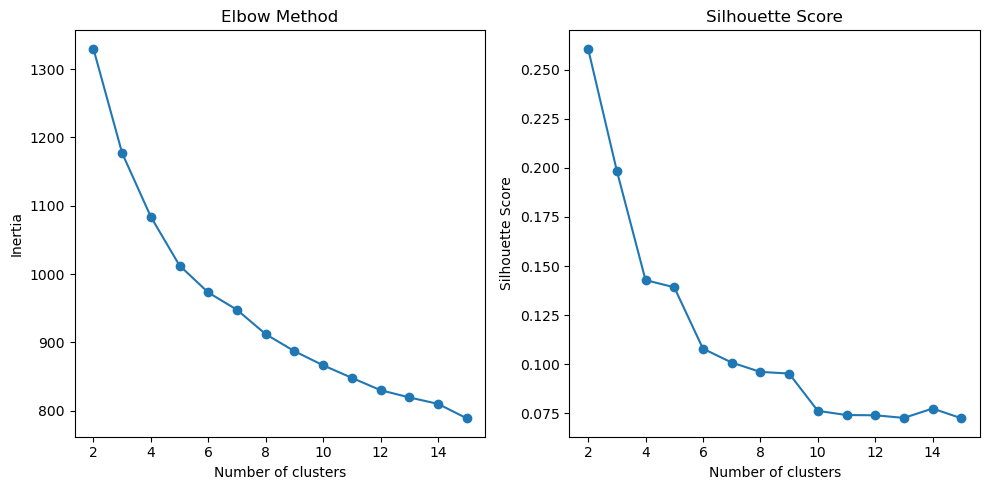

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# List to store inertia values for the Elbow Method and Silhouette Scores
inertia = []
sil_scores = []

# Range of cluster numbers to test (2 to 15 clusters, for example)
cluster_range = range(2, 16)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_list)
    
    # Append the inertia (sum of squared distances) for the Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Predict cluster labels and calculate silhouette score
    cluster_labels = kmeans.predict(features_list)
    sil_score = silhouette_score(features_list, cluster_labels)
    sil_scores.append(sil_score)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


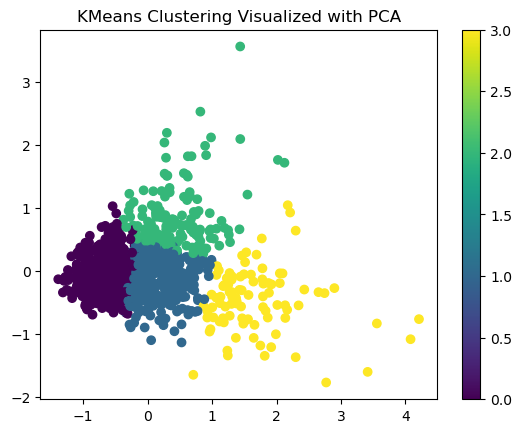

In [49]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Apply KMeans on the original feature list
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clustering Visualized with PCA')
plt.show()

_________

# DBSCAN Clustering

In [65]:
# Assuming features_list_scaled contains your scaled feature data
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

In [73]:
from sklearn.cluster import DBSCAN

# Assuming you've chosen an appropriate value for `eps`
dbscan = DBSCAN(eps=0.15, min_samples=5)  # Tune min_samples based on your data
dbscan_clusters = dbscan.fit_predict(features_pca)

# Check how many clusters and how many outliers (noise points)
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise = list(dbscan_clusters).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 6
Estimated number of noise points: 85


In [74]:
# Filter out noise points for silhouette score (-1 represents noise)
if n_clusters > 1:
    valid_clusters = dbscan_clusters[dbscan_clusters != -1]
    valid_features = features_pca[dbscan_clusters != -1]

    sil_score = silhouette_score(valid_features, valid_clusters)
    print(f'Silhouette Score for DBSCAN: {sil_score}')
else:
    print("Not enough clusters for Silhouette Score")

Silhouette Score for DBSCAN: 0.2830089330673218


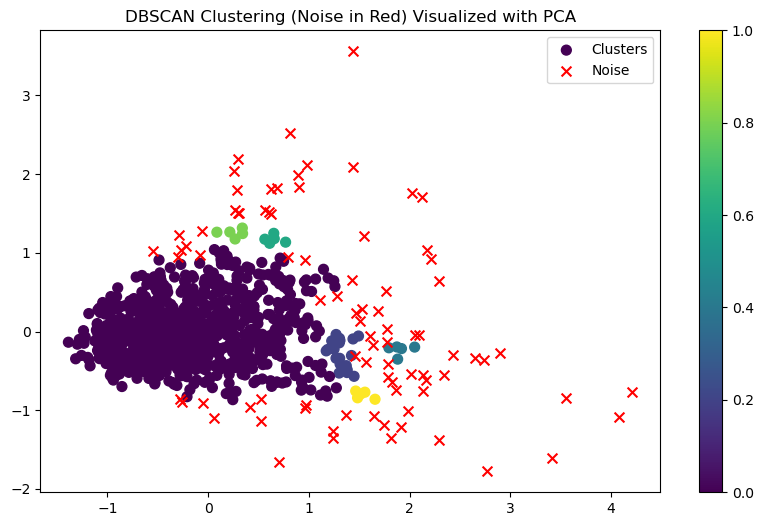

In [75]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.15, min_samples=5)  # Adjust 'eps' and 'min_samples' as needed
dbscan_clusters = dbscan.fit_predict(features_pca)

# Separate the noise (cluster -1) from the other clusters
core_samples_mask = dbscan_clusters != -1
noise_samples_mask = dbscan_clusters == -1

# Plot core clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[core_samples_mask, 0], features_pca[core_samples_mask, 1], 
            c=dbscan_clusters[core_samples_mask], cmap='viridis', s=50, label='Clusters')

# Plot noise samples
plt.scatter(features_pca[noise_samples_mask, 0], features_pca[noise_samples_mask, 1], 
            c='red', s=50, label='Noise', marker='x')

plt.colorbar()
plt.legend()
plt.title('DBSCAN Clustering (Noise in Red) Visualized with PCA')
plt.show()

_________

# Agglomerative Clustering

In [77]:
from sklearn.cluster import AgglomerativeClustering

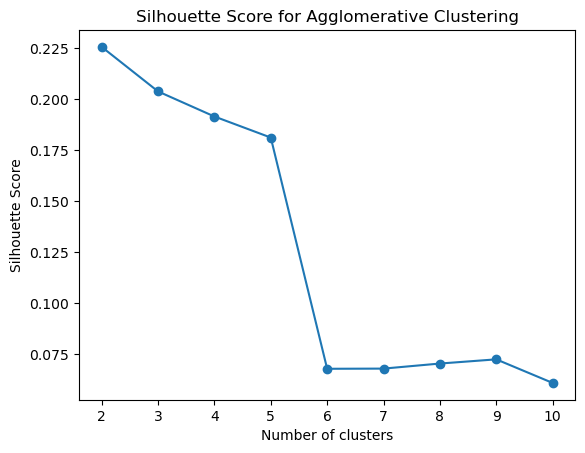

In [78]:
# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_clusters = agglo.fit_predict(features_list)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(features_list, agglo_clusters)
    sil_scores.append(sil_score)

# Plot the silhouette scores for different cluster numbers
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

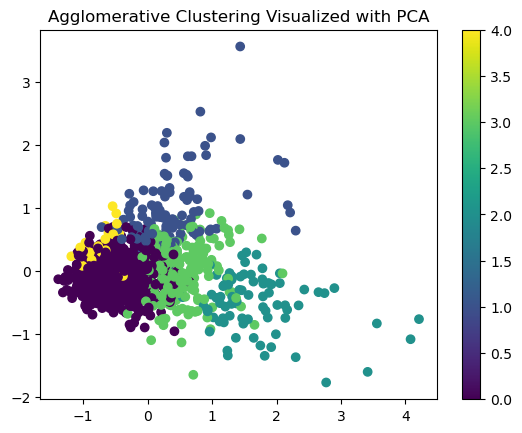

In [80]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Apply KMeans on the original feature list
agglo = AgglomerativeClustering(n_clusters=5)
clusters = agglo.fit_predict(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Agglomerative Clustering Visualized with PCA')
plt.show()

________

# GMM Clustering

In [81]:
from sklearn.mixture import GaussianMixture

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

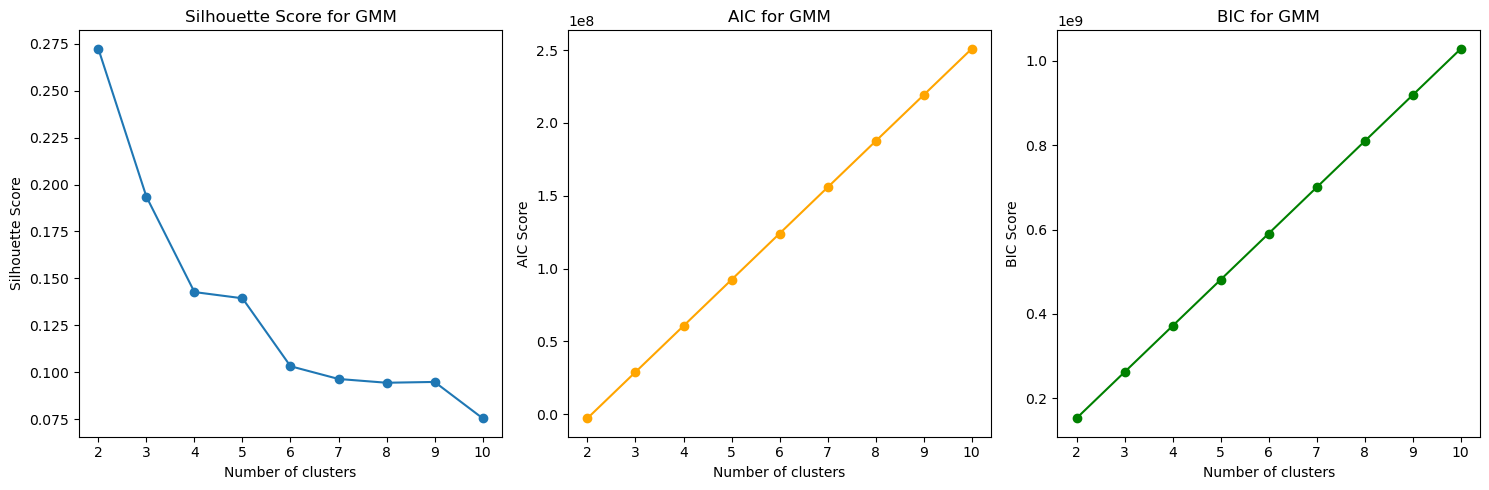

In [82]:
# Lists to store scores for different numbers of clusters
sil_scores = []
aic_scores = []
bic_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)  # Try different numbers of clusters

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Fit the GMM model
    gmm_clusters = gmm.fit_predict(features_list)
    
    # Calculate and append the silhouette score
    sil_score = silhouette_score(features_list, gmm_clusters)
    sil_scores.append(sil_score)
    
    # Append AIC and BIC scores
    aic_scores.append(gmm.aic(features_list))
    bic_scores.append(gmm.bic(features_list))

# Plot the results
plt.figure(figsize=(15, 5))

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Plot AIC Scores
plt.subplot(1, 3, 2)
plt.plot(cluster_range, aic_scores, marker='o', label='AIC', color='orange')
plt.title('AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')

# Plot BIC Scores
plt.subplot(1, 3, 3)
plt.plot(cluster_range, bic_scores, marker='o', label='BIC', color='green')
plt.title('BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


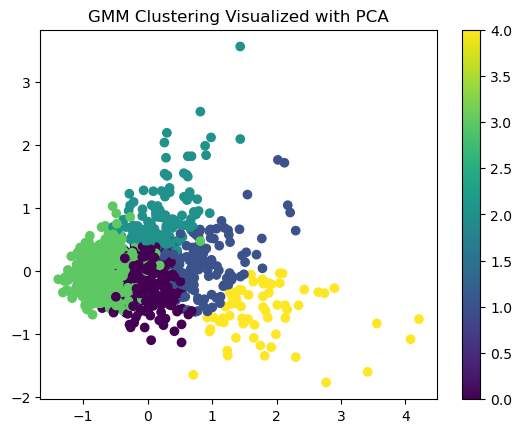

In [83]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Apply KMeans on the original feature list
gmm = GaussianMixture(n_components=5)
clusters = gmm.fit_predict(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('GMM Clustering Visualized with PCA')
plt.show()

______

# Spectral Clustering

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\env

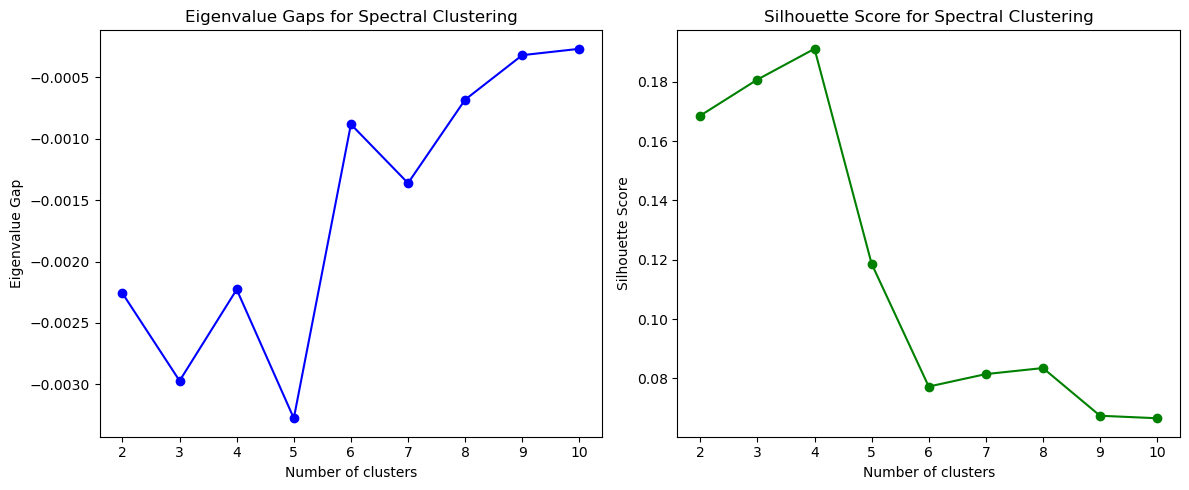

In [84]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding

# Define a function to calculate eigenvalue gap
def calculate_eigenvalue_gaps(features_list, cluster_range):
    eigenvalue_gaps = []
    
    for n_clusters in cluster_range:
        # Create the affinity matrix using k-nearest neighbors graph
        affinity_matrix = kneighbors_graph(features_list, n_neighbors=10).toarray()
        
        # Compute the spectral embedding (eigenvalues of Laplacian matrix)
        embedding = spectral_embedding(affinity_matrix, n_components=n_clusters)
        eigenvalues = np.linalg.svd(embedding, compute_uv=False)  # Get singular values (eigenvalues)
        
        # Compute the eigenvalue gaps
        eigenvalue_gaps.append(np.diff(eigenvalues).max())  # Largest gap between consecutive eigenvalues
    
    return eigenvalue_gaps

# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

# Calculate the eigenvalue gaps
eigenvalue_gaps = calculate_eigenvalue_gaps(features_list, cluster_range)

# Perform spectral clustering and calculate silhouette scores
for n_clusters in cluster_range:
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_list)
    
    # Calculate silhouette score
    sil_score = silhouette_score(features_list, cluster_labels)
    sil_scores.append(sil_score)

# Plot the eigenvalue gaps and silhouette scores side by side
plt.figure(figsize=(12, 5))

# Plot Eigenvalue Gaps
plt.subplot(1, 2, 1)
plt.plot(cluster_range, eigenvalue_gaps, marker='o', color='blue')
plt.title('Eigenvalue Gaps for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue Gap')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [85]:
# Apply Clustering on the original feature list
spectral = SpectralClustering(n_components=4)
clusters = spectral.fit_predict(features_list)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


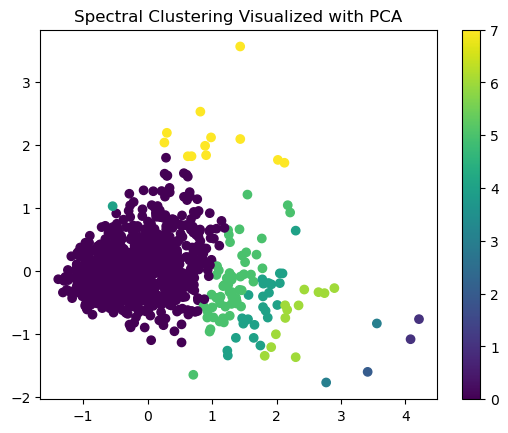

In [86]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Spectral Clustering Visualized with PCA')
plt.show()

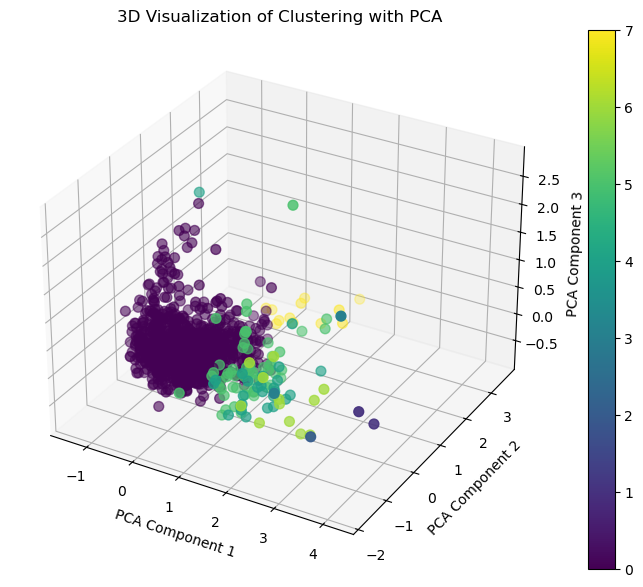

In [87]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_list)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA-reduced data in 3D with cluster labels as color
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], 
                     c=clusters, cmap='viridis', s=50)

# Add a colorbar
plt.colorbar(scatter)

# Set labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D Visualization of Clustering with PCA')

# Show plot
plt.show()

______

# Mean Shift Clustering

In [95]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate bandwidth for MeanShift algorithm (you can also manually set it)
bandwidth = estimate_bandwidth(features_list, quantile=0.2, n_samples=500)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=4.275, bin_seeding=True)
mean_shift_clusters = mean_shift.fit_predict(features_list)

# Print the number of clusters found
n_clusters = len(np.unique(mean_shift_clusters))
print(f'Number of clusters found: {n_clusters}')

Number of clusters found: 1


In [98]:
# sil_score = silhouette_score(features_list, mean_shift_clusters)
# print(f'Silhouette Score for Mean Shift: {sil_score}')

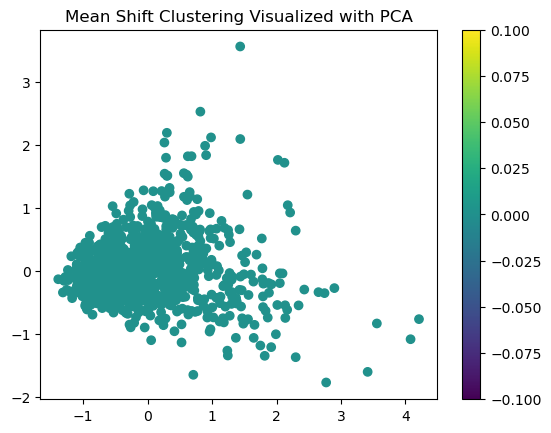

In [99]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=mean_shift_clusters, cmap='viridis')
plt.colorbar()
plt.title('Mean Shift Clustering Visualized with PCA')
plt.show()